In [1]:
import pandas as pd
import os

# 현재 파이썬 코드의 파일 경로
current_path = os.getcwd()  # 현재 작업 디렉토리를 가져옵니다.

# CSV 파일 경로
file_path = os.path.join(current_path, 'filtered_data.csv')  # User uploaded fioytle to this path

df = pd.read_csv(file_path)
df

,note id,person id,age,gender source value,BMI,admission department,division,ward,asa class,surgeon id,...,condition source value,surgery room,previous surgery,emergency status,op timing,day of the week,week of the month,month,surgeon estimated op time,surgery duration
0,101058,29,81,F,25.247087,General Surgery,Admission,NUGW2,2,9885,...,D00002196,203,N,N,TF2,Thursday,4,October,130,66
1,57801,64,60,F,24.376249,Otolaryngology,Admission,102,2,6194,...,D00003798,504,N,N,8A,Friday,2,January,300,130
2,71288,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF4,Monday,4,April,100,85
3,135104,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF2,Monday,3,August,100,83
4,221210,71,94,M,27.963140,Orthopedics,Admission,41,2,29473,...,D00018711,108,N,N,TF4,Monday,5,March,100,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161214,297111,4055249,1,M,23.700428,Pediatric Surgery,Admission,5A,1,100613,...,D00011688,5,N,Y,etc,Tuesday,2,September,200,123
161215,297455,4055328,1,M,20.612160,Pediatric Urology,Day,PDSC,1,6259,...,D00016707,7,N,N,8A,Monday,4,September,130,45
161216,297761,4055407,1,M,12.502703,Pediatric Surgery,Admission,5A,2,105057,...,D00011524,5,N,N,8A,Wednesday,3,September,130,43
161217,297753,4055558,4,F,14.365794,Pediatric Surgery,Admission,5A,2,105057,...,D00004831,5,N,N,TF6,Wednesday,3,September,130,82


In [2]:
from sklearn.model_selection import train_test_split

# Removing unnecessary columns
df.drop(columns=['note id', 'person id', 'surgeon estimated op time', 'final op name'], inplace=True)

# Encoding binary columns
binary_cols = ['condition source value']
for col in binary_cols:
    df[col] = df[col].astype('category').cat.codes

# One-hot encoding for other categorical columns
one_hot_cols = ['surgical department', 'op timing', 'month', 'anesthesia type', 'op code',
                'day of the week', 'asa class', 'week of the month', 
                'division', 'previous surgery', 'emergency status', 'gender source value', 'surgeon id', 'ward', 
                'admission department', 'surgery room']
df_encoded = pd.get_dummies(df, columns=one_hot_cols)

# Splitting the data
X_all = df_encoded.drop("surgery duration", axis=1)
y_all = df_encoded["surgery duration"]
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Displaying the first few rows of the resulting dataframe
X_train_all
y_train_all


61344     122
137241     48
139478     76
113549     36
149411    127
         ... 
119879     76
103694     57
131932    311
146867     82
121958     57
Name: surgery duration, Length: 128975, dtype: int64

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Preparing department-specific datasets
departments = df['surgical department'].unique()
department_models = {}
predictions = {}

# Training models for each department
for dept in departments:
    # Adjusting cWolumn name
    dept_col_name = 'surgical department_' + dept

    # Filtering data for the department
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery duration', axis=1)
    y_dept = dept_data['surgery duration']

    # Splitting the data
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # Training the model
    department_model = DecisionTreeRegressor(random_state=42)
    department_model.fit(X_train_dept, y_train_dept)
    department_models[dept] = department_model

    # Making predictions on the test dataset
    predictions[dept] = department_model.predict(X_test_dept)

# Preparing for ensemble
final_predictions = np.zeros(len(X_test_all))
test_indices = X_test_all.index

# Applying each department-specific model to the entire test dataset
for dept, department_model in department_models.items():
    # Adjusting column name
    dept_col_name = 'surgical department_' + dept

    # Indices of test data belonging to the department
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index

    # Calculating predictions for the department
    dept_predictions = department_model.predict(X_test_all.loc[dept_indices])

    # Updating the final prediction array
    final_predictions[np.isin(test_indices, dept_indices)] = dept_predictions

# Evaluating performance
mae_dt = mean_absolute_error(y_test_all, final_predictions)
rmse_dt = np.sqrt(mean_squared_error(y_test_all, final_predictions))
r2_dt = r2_score(y_test_all, final_predictions)

# The code is now updated with model names changed to 'department_model'
mae_dt, rmse_dt, r2_dt

(8.635280982508373, 32.8354048767889, 0.9094745086880096)

In [11]:
# Updated process for training, validation, and test split in a 7:2:1 ratio

department_models_updated = {}

for dept in departments:
    dept_col_name = 'surgical department_' + dept
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery duration', axis=1)
    y_dept = dept_data['surgery duration']

    # First split: Separating out the test set (10%)
    X_temp, X_test_dept, y_temp, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.1, random_state=42)

    # Second split: Separating the training set (70%) and validation set (20%)
    X_train_dept, X_val_dept, y_train_dept, y_val_dept = train_test_split(X_temp, y_temp, test_size=2/9, random_state=42)

    # Training the model
    department_model = DecisionTreeRegressor(random_state=42)
    department_model.fit(X_train_dept, y_train_dept)
    department_models_updated[dept] = department_model

# Preparing for ensemble predictions on the test set
final_predictions_updated = np.zeros(len(X_test_all))

for dept, department_model in department_models_updated.items():
    dept_col_name = 'surgical department_' + dept
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index
    dept_predictions = department_model.predict(X_test_all.loc[dept_indices])
    final_predictions_updated[np.isin(test_indices, dept_indices)] = dept_predictions

# Evaluating performance on the test set
mae_dt_updated = mean_absolute_error(y_test_all, final_predictions_updated)
rmse_dt_updated = np.sqrt(mean_squared_error(y_test_all, final_predictions_updated))
r2_dt_updated = r2_score(y_test_all, final_predictions_updated)

mae_dt_updated, rmse_dt_updated, r2_dt_updated


(13.304428730926684, 41.85730881166653, 0.8528945565461525)

In [4]:
# Calculating MAE, RMSE, and R² for each department-specific model
performance_per_department = {}

for dept, department_model in department_models.items():
    dept_col_name = 'surgical department_' + dept
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index
    
    # Extracting the relevant test data for the department
    X_test_dept = X_test_all.loc[dept_indices]
    y_test_dept = y_test_all.loc[dept_indices]

    # Calculating predictions for the department
    dept_predictions = department_model.predict(X_test_dept)

    # Calculating MAE, RMSE, and R² for the department
    mae_dept = mean_absolute_error(y_test_dept, dept_predictions)
    rmse_dept = np.sqrt(mean_squared_error(y_test_dept, dept_predictions))
    r2_dept = r2_score(y_test_dept, dept_predictions)
    performance_per_department[dept] = [mae_dept, rmse_dept, r2_dept]

# Converting the results to a DataFrame for better visualization
performance_df = pd.DataFrame.from_dict(performance_per_department, orient='index', columns=['MAE', 'RMSE', 'R²'])
performance_df_sorted = performance_df.sort_values(by='MAE')

performance_df_sorted

,MAE,RMSE,R²
Pediatric Ophthalmology,2.911616,9.085939,0.783366
Ophthalmology,3.479850,13.454084,0.843890
Pediatric Surgery,5.392390,19.723686,0.951856
Pediatric Otolaryngology,6.006135,24.568155,0.859530
Urology,6.425852,22.730291,0.908734
Pediatric Plastic Surgery,8.304740,30.006057,0.837012
Pediatric Urology,8.520070,31.665959,0.850861
General Surgery,9.146244,31.970481,0.908095
Obstetrics & Gynecology,9.886196,32.999069,0.847529
Plastic Surgery,10.053134,38.229558,0.894582


In [6]:
from sklearn.model_selection import cross_val_score

# Number of folds for cross-validation
n_folds = 5

# Extracting data for 'General Surgery' department
dept_col_name = 'surgical department_General Surgery'
general_surgery_data = df_encoded[df_encoded[dept_col_name] == 1]
X_general_surgery = general_surgery_data.drop('surgery duration', axis=1)
y_general_surgery = general_surgery_data['surgery duration']

# Initializing the Decision Tree Regressor for General Surgery
general_surgery_model = DecisionTreeRegressor(random_state=42)

# Performing cross-validation
cv_mae = cross_val_score(general_surgery_model, X_general_surgery, y_general_surgery, cv=n_folds, scoring='neg_mean_absolute_error')
cv_rmse = cross_val_score(general_surgery_model, X_general_surgery, y_general_surgery, cv=n_folds, scoring='neg_root_mean_squared_error')
cv_r2 = cross_val_score(general_surgery_model, X_general_surgery, y_general_surgery, cv=n_folds, scoring='r2')

# Converting negative scores to positive for MAE and RMSE
cv_mae = -cv_mae
cv_rmse = -cv_rmse

cv_results = {
    "MAE": cv_mae,
    "RMSE": cv_rmse,
    "R²": cv_r2
}

cv_results_df = pd.DataFrame(cv_results)

cv_results_df


,MAE,RMSE,R²
0,47.457636,72.450637,0.415561
1,45.818045,70.699148,0.495180
2,50.854792,78.234814,0.463771
3,52.269505,81.035912,0.439806
4,51.314274,79.342631,0.491225


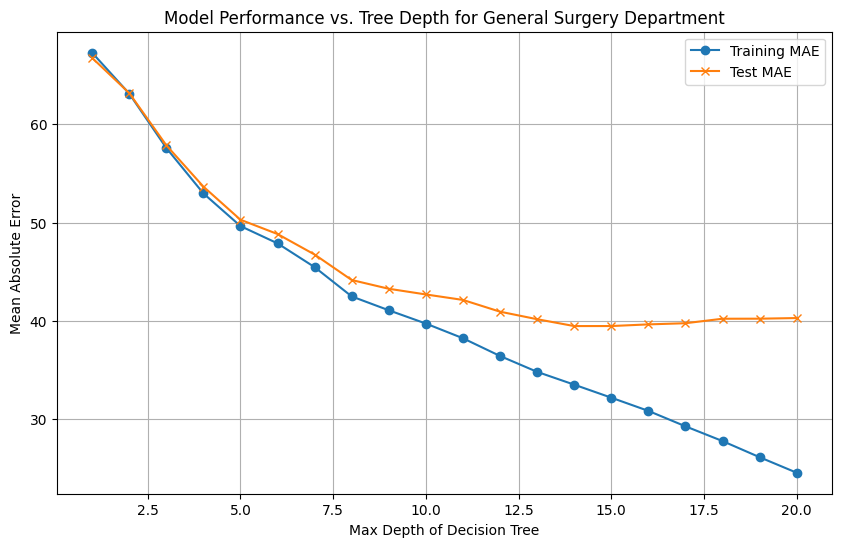

In [7]:
import matplotlib.pyplot as plt

# Extracting training and test data for 'General Surgery'
X_train_gs, X_test_gs, y_train_gs, y_test_gs = train_test_split(X_general_surgery, y_general_surgery, test_size=0.2, random_state=42)

# Lists to store the performance metrics for different tree depths
train_mae = []
test_mae = []
max_depth_range = range(1, 21)  # Considering tree depths from 1 to 20

# Calculating MAE for different tree depths
for depth in max_depth_range:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    model.fit(X_train_gs, y_train_gs)

    # Predicting and calculating MAE for training set
    train_pred = model.predict(X_train_gs)
    train_mae.append(mean_absolute_error(y_train_gs, train_pred))

    # Predicting and calculating MAE for test set
    test_pred = model.predict(X_test_gs)
    test_mae.append(mean_absolute_error(y_test_gs, test_pred))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, train_mae, label='Training MAE', marker='o')
plt.plot(max_depth_range, test_mae, label='Test MAE', marker='x')
plt.xlabel('Max Depth of Decision Tree')
plt.ylabel('Mean Absolute Error')
plt.title('Model Performance vs. Tree Depth for General Surgery Department')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# Identifying the optimal maximum tree depth
optimal_depth = max_depth_range[test_mae.index(min(test_mae))]

optimal_depth


14

In [9]:
# Retraining the model with the optimal depth
optimal_gs_model = DecisionTreeRegressor(max_depth=optimal_depth, random_state=42)
optimal_gs_model.fit(X_train_gs, y_train_gs)

# Predicting on the test set
optimal_gs_predictions = optimal_gs_model.predict(X_test_gs)

# Evaluating the performance
optimal_mae = mean_absolute_error(y_test_gs, optimal_gs_predictions)
optimal_rmse = np.sqrt(mean_squared_error(y_test_gs, optimal_gs_predictions))
optimal_r2 = r2_score(y_test_gs, optimal_gs_predictions)

optimal_mae, optimal_rmse, optimal_r2


(39.46434401711331, 61.64413429672718, 0.6399680873025326)